In this notebook we will be exploring the implementation of various collision detection algorithms from scratch. There is a good amount of code in the simulationLibrary module relating to this. So far we have implemented a basic, brute force, $O(n^2)$ method (kinda). Im convinced there is some janky floating point arithmetic that is messing up everything and causing infinite clipping issues (usually manifesting as two objects becoming stuck together).

Moving forward, my goals are as stated below. Obviously, this is an ongoing passion project and will continue to be expanded on over time. But the most recent goals are as follows:
- [ ] Clean up the brute-force algorithm. Fix the clipping issues, fix the graphing, make it smoother in general, so on so forth
- [ ] Implement the axis aligned bounding boxes algorithm
- [ ] Make sure that the code is modular enough to easily swap out algorithms at will
- [ ] Generalize update function
- [ ] Clean up plotting. Switch to matplotlib.animate if possible (if not, maybe find a way anyways? Seems like I should)

In [1]:
# ffmpeg -start_number 0 -framerate 60 -i graph%01d.png video.webm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as rnd
import math
import os
import sys

In [3]:
# We have this cell here to call the dataAnalysisLibrary module from one place rather than copy pasting into many other places
# The path here is my own path, will need to change it for whoever is using
# Want to find a way to do this automatically so the reader doesnt have to worry about it
# I really need to generalize this...

sys.path.insert(0,'./simulationLibrary')
import simulationLibrary as sim

In [4]:
#Class defining a particle used in the simulation
class Particle:
    def __init__(self, mass, position, velocity, acceleration, box):
        
        self.mass = mass
        self.radius = math.sqrt(self.mass/(math.pi*1.5))
        self.position = position
        self.velocity = velocity
        self.acceleration = acceleration
        self.KE = (1/2)*self.mass*np.dot(self.velocity,self.velocity)

    # Use properties for the particle boundaries
    @property
    def left(self):
        return self.position[0] - self.radius
    
    @property
    def right(self):
        return self.position[0] + self.radius
    
    @property
    def top(self):
        return self.position[1] + self.radius
    
    @property
    def bottom(self):
        return self.position[1] - self.radius
    
    #Method that detects if there is a colision between the particle and the box
    def handleBoxCollision(self, box):
        #cor is the coefficient of restitution
        cor = 0.9
        if self.left <= box.left or self.right >= box.right:
            self.velocity[0]=-self.velocity[0]
        
        if self.bottom <= box.bottom or self.top >= box.top:
            self.velocity[1]=-self.velocity[1]
    
        #These statements make sure that the ball is put back into the box, rather than letting it clip though
        if self.top >= box.top:
            self.position[1] = box.top - self.radius
        
        if self.bottom <= box.bottom:
            self.position[1] = box.bottom + self.radius
        
        if self.left <= box.left:
            self.position[0] = box.left + self.radius
        
        if self.right >= box.right:
            self.position[0] = box.right - self.radius
        
#just defining the box tha5t the simulation takes place in
class Box:
    def __init__(self):
        self.left = -10
        self.right = 10
        self.bottom = -10
        self.top = 10

In [4]:
def handleParticleCollision(pa,pb):
    """
    Description
    -----------
    Computes the next step in the Lorenz attractor system.

    Parameters
    ----------
    pa, pb : objects
        objects generated from the Particle() class

    Returns 
    -------
    Nothing! But updates the positions of all the objects in the object list
    """
    if math.dist(pa.position,pb.position) <= (pa.radius+pb.radius):
        P1 = pa.position
        P2 = pb.position
        v1 = pa.velocity
        v2 = pb.velocity
        m1 = pa.mass
        m2 = pb.mass

        r1=pa.radius
        r2=pb.radius

        a = np.linalg.norm(v1-v2)**2
        b = 2*np.inner(v1-v2,P1-P2)
        c= np.linalg.norm(P1-P2)**2-(r1+r2)**2

        # calculating  the discriminant
        dis = (b**2) - (4 * a*c)
        
        # The first result is when they make contact
        ans1 = (-b-math.sqrt(dis))/(2 * a)
        
        temp3 = pa.position+pa.velocity*ans1
        temp4 = pb.position+pb.velocity*ans1 
        
        temp1 = v1-((2*m2)/(m1+m2))*(np.inner(v1-v2,P1-P2)/np.linalg.norm(P1-P2)**2)*(P1-P2)
        temp2 = v2-((2*m1)/(m1+m2))*(np.inner(v2-v1,P2-P1)/np.linalg.norm(P2-P1)**2)*(P2-P1)
        pa.velocity = temp1
        pb.velocity = temp2
        pa.position = temp3
        pb.position = temp4
        
#Since this is a discreet colission simulation this function is for updating the state of the simulation
def update(dt):
    p1.velocity = p1.velocity+(p1.acceleration*dt)
    p1.position = p1.position+(p1.velocity*dt)
    p1.KE = (1/2)*p1.mass*np.dot(p1.velocity,p1.velocity)
    
    p2.velocity = p2.velocity+(p2.acceleration*dt)
    p2.position = p2.position+(p2.velocity*dt)
    p2.KE = (1/2)*p2.mass*np.dot(p2.velocity,p2.velocity)
    
    p1.handleBoxCollision(box)
    p2.handleBoxCollision(box)
    
    handleParticleCollision(p1,p2)

KeyboardInterrupt: 

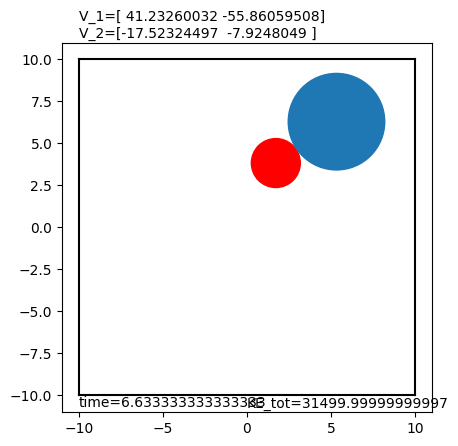

In [5]:
%%time
    
dir = 'C:/Users/darkb/Documents/Uidaho Classes/CS shit/Physics Simulations/Images for simulation'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

#Initial mass, position, velocity and acceleration
mass = 10
position = np.array([-4,7])
velocity = np.array([50,30])
acceleration = np.array([0,0])

mass1 = 40
position1 = np.array([5,3.7])
velocity1 = np.array([-25, 10])
acceleration1 = np.array([0,0])

#time step = 1/framerate
dt = 1/60

box = Box()
p1 = Particle(mass, position, velocity, acceleration, box)
p2 = Particle(mass1, position1, velocity1, acceleration1, box)

#Run this loop for however many frames I want. In this case 600
for i in range(600):
    figure, axes = plt.subplots()
    
    update(dt)
    totalKE=p1.KE+p2.KE
    
    #left of box
    plt.plot([-10,-10],[-10,10],color='black')
    #right of box
    plt.plot([10,10],[-10,10],color='black')
    #top of box
    plt.plot([-10,10],[10,10],color='black')
    #bottom of box
    plt.plot([-10,10],[-10,-10],color='black')
    
#     plt.arrow(p1.position[0],p1.position[1],p1.velocity[0],p1.velocity[1])
#     plt.arrow(p2.position[0],p2.position[1],p2.velocity[0],p2.velocity[1])
    
    cc1 = plt.Circle((p1.position[0] ,p1.position[1]), p1.radius, color="red")
    cc2 = plt.Circle((p2.position[0] ,p2.position[1]), p2.radius)

#     plt.scatter(p1.position[0],p1.position[1])
#     plt.scatter(p2.position[0],p2.position[1])
    plt.xlim(-11,11)
    plt.ylim(-11,11)
    plt.text(-10,-10.7,"time="+str(i*dt))
    plt.text(-10,12.3,"V_1="+str(p1.velocity))
    plt.text(-10,11.3,"V_2="+str(p2.velocity))
#     plt.text(0,11.3,"KE_1="+str(p1.KE))
#     plt.text(0,12.3,"KE_2="+str(p2.KE))
    plt.text(0,-10.7,"KE_tot="+str(totalKE))
    axes=plt.gca()
    axes.add_artist(cc1)
    axes.add_artist(cc2)
    axes.set_aspect(1)
    
#     plt.show()
    figure.savefig('/Users/darkb/Documents/Uidaho Classes/CS shit/Physics Simulations/Images for simulation/graph'+str(i)+'.png')
    plt.close('all')

In [4]:
# Im going to redo everything I did above down here based on the framework of what I have above.
# Some things are going to change radically but thats alright aslong as I can get everything working again

In [15]:
def clearDirectory(direc='./Images for simulation'):
    """
    Description
    -----------
    Deletes the contents of a target directory.

    Parameters
    ----------
    direc : string
       string containing the path to your target directory. Default is the essential 'Images for Simulation' library since thats what we use the most, but you can put in whatever you want.

    Returns
    -------
    Nothing. But! This function does delete the contents of another folder.
    """
    dir = direc
    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))

In [6]:
class Particle:
    def __init__(self, mass, position, velocity, acceleration, box):
        
        self.mass = mass
        self.radius = math.sqrt(self.mass/(math.pi*1.5))
        self.position = position
        self.velocity = velocity
        self.acceleration = acceleration
        self.KE = (1/2)*self.mass*np.dot(self.velocity,self.velocity)

    # Use properties for the particle boundaries
    @property
    def left(self):
        return self.position[0] - self.radius
    
    @property
    def right(self):
        return self.position[0] + self.radius
    
    @property
    def top(self):
        return self.position[1] + self.radius
    
    @property
    def bottom(self):
        return self.position[1] - self.radius

In [7]:
def randParticle(massMean=1*10**12, massStdDev=100000000000, posMean = 0, posStdDev = 15, velMean = 0, velStdDev = 0.2, type='gravity'):
    """
    Description
    -----------
    randParticleGravity() just generates a random particle with Gaussian distributed mass, position and velocity.

    Parameters
    ----------
    massMean : float
        mean of the randomly decided mass. Default argument arbitrarily chosen tailored for gravity simulations.
    massStdDev : float
        standard deviation mass of the randomly decided mass. Default argument arbitrarily chosen tailored for gravity simulations.
    posStdDev : float
        standard deviation mass of the randomly decided position. Default argument arbitrarily chosen tailored for gravity simulations.
    velStdDev : float
        standard deviation mass of the randomly decided velocity. Default argument arbitrarily chosen tailored for gravity simulations.

    Returns
    -------
    particle : PointMassBody() object, dtype='object'
        Returns a PointMassBody() object with randomly decided mass, position and velocity.
    """
    #Declare randomly assigned mass
    mass = np.random.normal(loc=massMean,scale=massStdDev)
    
    #Declare randomly assigned positions and make sure it doesnt go out of bounds
    posx = np.random.normal(loc=posMean, scale=posStdDev)
    posy = np.random.normal(loc=posMean, scale=posStdDev)
    if posx < -10 or posx > 10:
        posx = 80
    if posy >= 80:
        posy = 80
    position = np.array([posx,posy])
    
    #Declare randomly assigned positions and make sure it doesnt go out of bounds
    velx = np.random.normal(loc=velMean, scale=velStdDev)
    vely = np.random.normal(loc=velMean, scale=velStdDev)
    velocity = np.array([velx,vely])

    #Generate and return the particle
    if type == 'gravity':
        particle = sim.PointMassBody(mass,position,velocity,np.array([0,0]))
    else:
        particle = Particle(mass,position,velocity,np.array([0,0]))
    return(particle)

In [8]:
#just defining the box tha5t the simulation takes place in
class Box:
    def __init__(self):
        self.left = -10
        self.right = 10
        self.bottom = -10
        self.top = 10

In [16]:
# Now we are going to try to modularize the whole collision detection algorithm
def collisionDetection(numParticles = 10, numFrames = 100):
    clearDirectory()
    
    # Initialize the box
    box=Box()
    
    # Declare the particles and throw them in to an array.
    bodies = np.array([])
    for i in range(numParticles):
        bodies=np.append(bodies,randParticle())
        
    for i in range(numFrames)

    # Run loop:
    #     Check for collisions

In [10]:
# declare objects
# Put objects in array

# Declare box

# Run loop:
#     Check for collisions

In [ ]:
def updateCollisionBruteForce(bodies, dt):
    
    posMatrix = np.zeros((len(bodies),len(bodies)))
    for i in range(len(bodies)):
        
    
    p1.velocity = p1.velocity+(p1.acceleration*dt)
    p1.position = p1.position+(p1.velocity*dt)
    p1.KE = (1/2)*p1.mass*np.dot(p1.velocity,p1.velocity)
    
    p2.velocity = p2.velocity+(p2.acceleration*dt)
    p2.position = p2.position+(p2.velocity*dt)
    p2.KE = (1/2)*p2.mass*np.dot(p2.velocity,p2.velocity)
    
    p1.handleBoxCollision(box)
    p2.handleBoxCollision(box)
    
    handleParticleCollision(p1,p2)